## Nick Riccobono

### Comparing semisubmersible cost and weights model
* Baseline: ORBIT semisubmersible_design 
* Custom: New semisubmersible_pontoon_design based on UMaine's reference platform [1]

[1] C. Allen et al., “Definition of the UMaine VolturnUS-S Reference Platform Developed for the IEA Wind 15-Megawatt Offshore Reference Wind Turbine,” NREL/TP--5000-76773, 1660012, MainId:9434, Jul. 2020. doi: 10.2172/1660012.

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

## Gather check data from the two upscaling case studies proposed in U-Mass paper [2]

1) OC4 platform: reference turbine NREL-5MW, scales up to 20MW 
2) IEA platform: reference turbine IEA-15MW, scales up to 30MW 

[2] K. L. Roach, M. A. Lackner, and J. F. Manwell, “A New Methodology for Upscaling Semi-submersible Platforms for Floating Offshore Wind Turbines,” Wind Energy Science Discussions, pp. 1–33, Feb. 2023, doi: 10.5194/wes-2023-18.

In [18]:
# Check data for OC4 platform upscaling *Not really used anymore*

# NREL 5MW reference turbine
ref_radius = 63 # m

Sp = 5e6 / np.pi / ref_radius**2 # Eq. 6
print(f"Specific Power: {Sp:.0f} W/m**2")

new_power = np.array([5e6, 10e6, 15e6, 20e6])
new_radius = [np.sqrt(x/ np.pi / Sp) for x in new_power]

print("OC4 Upscaling:")
print("Power Rating: ", new_power/1e6, "MW")
print("Radius: ", np.round(new_radius), "m")

# Table 9
oc4_check_data = {'turbine_rating': new_power / 1e6,
                    'steel mass': np.array([3.59e6, 5.6e6, 7.3e6, 8.86e6]) / 1e3,
                    'platform mass': np.array([1.3e7, 2.5e7, 3.7e7, 4.9e7]) /1e3,
                    }
 

Specific Power: 401 W/m**2
OC4 Upscaling:
Power Rating:  [ 5. 10. 15. 20.] MW
Radius:  [ 63.  89. 109. 126.] m


In [19]:
# Check data for IEA platform upscaling 

# IEA 15MW reference turbine 
ref_radius = 120 # m

# Upscaling Methodology (U-Mass.)
Sp = 15e6 / np.pi / ref_radius**2 # Eq. 6
print(f"Specific Power: {Sp:.0f} W/m**2")

new_power = np.array([15e6, 20e6, 25e6, 30e6])
new_radius = [np.sqrt(x/ np.pi / Sp) for x in new_power]

print("Upscaled Power Rating: ", new_power/1e6, "MW")
print("Upscaled Radius: ", np.round(new_radius), "m")

alpha_iea = 1.5
scale_factor_iea = ( np.array(new_radius) / ref_radius ) ** alpha_iea

# Table 10
iea_check_data = {'turbine_rating': new_power/1e6,
                    'steel mass': np.array([3.5e6, 4.7e6, 6.0e6, 7.3e6]) / 1e3,
                    'platform mass': np.array([1.8e7, 2.5e7, 3.2e7, 3.9e7]) /1e3,
                    'steel mass curve': (3.5e6) * scale_factor_iea / 1e3
                    }

#print(f"Upscaled Mass: {umass_check_data['platform mass']} tonnes" )
#ref_mass = 6454 # tonnes, steel hull + fixed ballast 



Specific Power: 332 W/m**2
Upscaled Power Rating:  [15. 20. 25. 30.] MW
Upscaled Radius:  [120. 139. 155. 170.] m


### Gather semisubmersible model data 
* baseline: ORBIT 
* custom_IEA: IEA platform, scale factor alpha=0.72, wall-thickness=4.5cm
* custom_IEA2: IEA platform, scale factor alpha=0.72, wall-thickness=6.5cm 

In [20]:
outputs_dir = os.path.join(os.getcwd(), 'outputs')

# Replicate these dataframes for additional files
baseline_file = "orbit_semisub_cost_model_baseline.csv"
baseline_df = pd.read_csv(os.path.join(outputs_dir, baseline_file))

custom_IEA_file = "orbit_semisub_cost_model_custom_IEA.csv"
custom_IEA_df = pd.read_csv(os.path.join(outputs_dir, custom_IEA_file))

custom_IEA2_file = "orbit_semisub_cost_model_custom_IEA2.csv"
custom_IEA2_df = pd.read_csv(os.path.join(outputs_dir, custom_IEA2_file))

custom_IEA_df.tail()

,Unnamed: 0,mass,unit_cost,towing_speed,Turbine Rating
0,0,6907.0,19583341.0,6,12MW
1,1,7671.0,23018298.0,6,15MW
2,2,8184.0,25329736.0,6,17MW
3,3,8415.0,26368330.0,6,18MW
4,4,8853.0,28340853.0,6,20MW


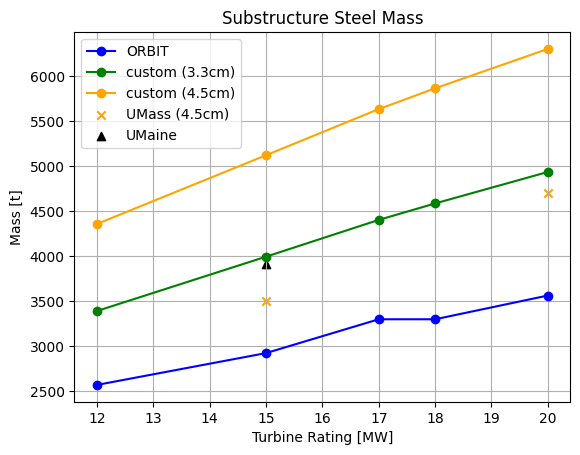

In [21]:
# Plot baseline (ORBIT) versus custom (IEA semisub)
turbine_rating = [float(x[0:2]) for x in baseline_df['Turbine Rating']]

fig, ax = plt.subplots(1,1)
ax.set_title('Substructure Steel Mass')
ax.plot(turbine_rating, baseline_df['mass'], color='blue', label='ORBIT',marker='o')

ax.plot(turbine_rating, custom_IEA2_df['mass'] - 2450 - 100, color='green', label='custom (3.3cm)',marker='o')
ax.plot(turbine_rating, custom_IEA_df['mass']- 2450 - 100, color='orange', label='custom (4.5cm)',marker='o')
ax.scatter(iea_check_data['turbine_rating'][0:2], iea_check_data['steel mass'][0:2], color='orange', label='UMass (4.5cm)', marker='x')
ax.scatter(15, 3914, color='black', label='UMaine', marker='^')

ax.set_xlabel('Turbine Rating [MW]')
ax.set_ylabel('Mass [t]')
ax.legend(loc='upper left')
ax.grid()
plt.show()

#print("15MW error", abs(iea_check_data['steel mass'][0] - (custom_IEA_df['mass'][1] - 2540))/iea_check_data['steel mass'][0])
#print("20MW error", abs(iea_check_data['steel mass'][1] - (custom_IEA_df['mass'][3] - 2540))/iea_check_data['steel mass'][1])


[ -19.73665834 1500.31966853]
[12.0, 15.0, 17.0, 18.0, 20.0]
1105.5865018261059


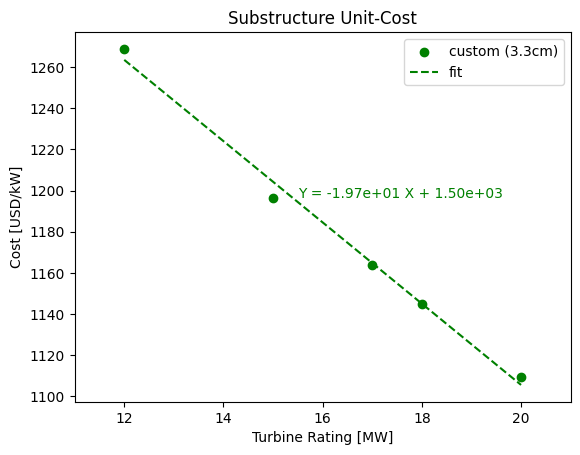

Cost of steel per kW
0    1237.125000
1    1170.900000
2    1141.411765
3    1123.750000
4    1090.125000
Name: mass, dtype: float64


In [89]:
# get curve fit data for unit cost 

# Simple power rule formula
def func (x, m, b):
    
    return m*x + b

xdata = [float(x[0:2]) for x in baseline_df['Turbine Rating']] # turbine rating in MW
ydata0 = baseline_df['unit_cost'].divide(xdata).divide(1e3)
ydata1 = custom_IEA_df['unit_cost'].divide(xdata).divide(1e3) # steel mass in tons 
ydata2 = custom_IEA2_df['unit_cost'].divide(xdata).divide(1e3) # steel mass in tons 

#popt0, pcov0 = curve_fit(func, xdata, ydata0)
#print(popt0)
#print(xdata)
#print(func(xdata, *popt0))
#s0 = f"Y = {popt0[1]:.2e} X^{popt0[0]:0.3f} {popt0[2]:0.2e}" 
#popt1, pcov1 = curve_fit(func, xdata, ydata1)
#print(popt)
#s1 = f"Y = {popt1[1]:.2e} X^{popt1[0]:0.3f} {popt1[2]:0.2e}" 
popt2, pcov2 = curve_fit(func, xdata, ydata2)
print(popt2)
print(xdata)
print(func(np.array(xdata[-1]), *popt2))

#print(popt2)
s2 = f"Y = {popt2[0]:0.2e} X + {popt2[1]:0.2e}" 

fig, ax = plt.subplots(1,1)
ax.set_title('Substructure Unit-Cost')
#ax.scatter(turbine_rating, baseline_df['unit_cost']/turbine_rating/1e3, color='blue', label='ORBIT',marker='o')
#ax.plot(func(xdata, *popt0), '--b', label='fit')
#ax.text(xdata[4] - 4.5, (ydata0[4]), s0,color='blue')

# Changed up the labels for BOEM plots 
# ax.scatter(turbine_rating, custom_IEA2_df['unit_cost']/turbine_rating/1e3, color='green', label='custom (3.3cm)',marker='o')
ax.scatter(turbine_rating, custom_IEA2_df['unit_cost']/turbine_rating/1e3, color='green', label='ORBIT',marker='o')
#ax.plot(np.array(xdata), func(np.array(xdata), *popt2), '--', color='green', label='fit')
ax.plot(np.array(xdata), func(np.array(xdata), *popt2), '--', color='green', label='Cost Curve')
#ax.text(xdata[1]+0.5, ydata2[1], s2,color='green')
#ax.scatter(turbine_rating, custom_IEA_df['unit_cost']/turbine_rating/1e3, color='orange', label='custom (4.5cm)',marker='o')
#ax.plot(func(xdata, *popt1), '--', color='orange', label='fit')
#ax.text(xdata[4] - 4.5, ydata1[4], s1,color='orange')

ax.set_xlabel('Turbine Rating [MW]')
ax.set_ylabel('Cost [USD/kW]')
ax.legend(loc='upper right')
ax.set_xlim([11, 21])
plt.show()

print("Cost of steel per kW")
print((custom_IEA2_df['mass']- 2540 - 100)*4500/turbine_rating/1e3)